<a href="https://colab.research.google.com/github/nevelshute/AreAre/blob/master/acoustic_scene_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acoustic Scene Classification

This guide will show you how to build a basic acoustic scene classification network that recognizes 3 different acoustic scenes:
- Indoor
- Outdoor
- In-vehicle

Let's get started by first downloading some custom modules:

In [ ]:
!wget https://gist.githubusercontent.com/glegrain/13276fb57007905180f5455be7a3d6cd/raw/tutacousticscenes2016.py

--2019-10-21 09:11:49--  https://gist.githubusercontent.com/glegrain/13276fb57007905180f5455be7a3d6cd/raw/tutacousticscenes2016.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7680 (7.5K) [text/plain]
Saving to: ‘tutacousticscenes2016.py’

tutacousticscenes20 100%[===================>]   7.50K  --.-KB/s    in 0s      

2019-10-21 09:11:50 (112 MB/s) - ‘tutacousticscenes2016.py’ saved [7680/7680]



In [ ]:
!wget https://gist.githubusercontent.com/glegrain/bebc5a801c0896c9429dab9cb4dfaaf1/raw/LogMelSpectrogram.py

--2019-10-21 09:11:55--  https://gist.githubusercontent.com/glegrain/bebc5a801c0896c9429dab9cb4dfaaf1/raw/LogMelSpectrogram.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1734 (1.7K) [text/plain]
Saving to: ‘LogMelSpectrogram.py’

LogMelSpectrogram.p 100%[===================>]   1.69K  --.-KB/s    in 0s      

2019-10-21 09:11:55 (385 MB/s) - ‘LogMelSpectrogram.py’ saved [1734/1734]



In [ ]:
# Fixing random state for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

## Download the **TUT Acoustic scenes 2016** dataset

The [TUT Acoustic scenes 2016][1] dataset will be used for the task. The dataset consists of recordings from various acoustic scenes, all having distinct recording locations. 

A module has been created to download the TUT Acoustic scenes 2016 dataset to your machine (or uses a cached copy if you've already downloaded it because there is around 10GB of data). Original recordings were captured using a 44.1kHz sampling rate, stereo and 24-bit resolution. During the loading process, the audio data is resampled to 16kHz, mono and converted to normalized floating point values.

Use the following code to use the module:

[1]: http://www.cs.tut.fi/sgn/arg/dcase2016/task-acoustic-scene-classification

In [ ]:
import tutacousticscenes2016

(x_dev, y_dev), (x_eval, y_eval) = tutacousticscenes2016.load_data()

Using TensorFlow backend.


8192/5962 [=========================================] - 0s 0us/step
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development.audio.1.zip
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development.audio.2.zip
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development.audio.3.zip
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development.audio.4.zip
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development.audio.5.zip
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development.audio.6.zip
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development.audio.7.zip
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development.audio.8.zip
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development.doc.zip
Extracting ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-

  0%|          | 0/1170 [00:00<?, ?it/s]

Loading wav files to ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-development


  0%|          | 0/390 [00:00<?, ?it/s]

Loading wav files to ./datasets/TUT-acoustic-scenes-2016/TUT-acoustic-scenes-2016-evaluation


100%|██████████| 390/390 [11:05<00:00,  1.71s/it]


Labels (i.e. `y_train` and `y_test`) are returned as arrays of index from 0 to 2. You can use a list of strings with the corresponding class names to make the matching. 

In [ ]:
class_names = ['indoor', 'outdoor', 'vehicle']

## Explore the data
Let's make sure the data we have downloaded actually makes sense. The dataset has been converted to mono and resampled to 16kHz.

In [ ]:
print('x_dev shape:', x_dev.shape)
print(x_dev.shape[0], 'development samples')
print(x_eval.shape[0], 'evaluation samples')

x_dev shape: (1170, 480001)
1170 development samples
390 evaluation samples


The development dataset is composed of:
- 6 x 78 = 468 30s segments for *indoor*
- 5 x 78 = 390 30s segments for *outdoor*
- 4 x 78 = 312 30s segments for *outdoor* 

(array([468., 390., 312.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

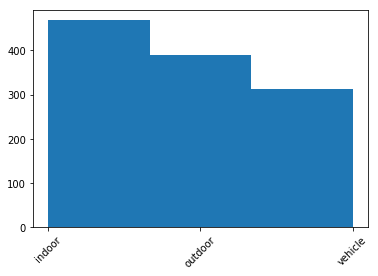

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.hist(y_dev, bins=len(class_names))

Similarly, the evaluation dataset is composed of:
- 6 x 26 = 156 30s segments for *indoor*
- 5 x 26 = 120 30s segments for *outdoor*
- 4 x 26 = 104 30s segments for *outdoor* 

(array([156., 130., 104.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

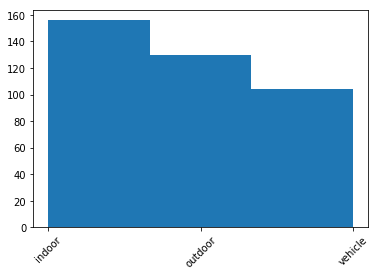

In [ ]:
plt.figure()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.hist(y_eval, bins=len(class_names))

Let's plot the first few audio samples from the first audio file:

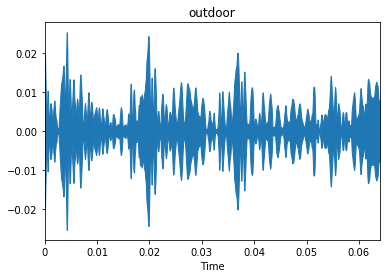

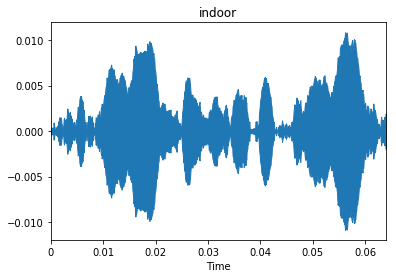

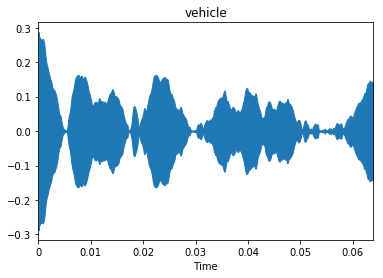

In [ ]:
import librosa.display

plt.figure()
plt.title(class_names[y_dev[0]])
librosa.display.waveplot(x_dev[0][:1024], sr=16000)


plt.figure()
plt.title(class_names[y_dev[120]])
librosa.display.waveplot(x_dev[120][:1024], sr=16000)

plt.figure()
plt.title(class_names[y_dev[167]])
librosa.display.waveplot(x_dev[167][:1024], sr=16000)

## Prepare the data
Slice the 30s signal into overlapping frames of 1024ms to return 936 frames of 1024 samples:

In [ ]:
import numpy as np
import librosa.util

x_dev_framed = []
for i in range(x_dev.shape[0]):
    frames = librosa.util.frame(x_dev[i], frame_length=1024, hop_length=512)
    x_dev_framed.append(np.transpose(frames))

And check that we are getting a list of 1,170 samples with 936 frames of 1024 samples:

In [ ]:
print(len(x_dev_framed))
print(x_dev_framed[0].shape)

1170
(936, 1024)


And plot the first frame to make sure we are getting the same data as previsously plotted:

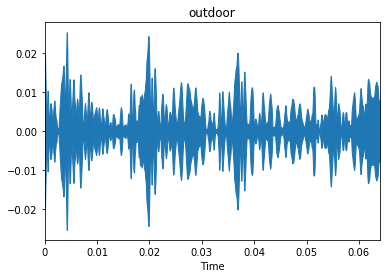

In [ ]:
plt.figure()
plt.title(class_names[y_dev[0]])
librosa.display.waveplot(np.ascontiguousarray(x_dev_framed[0][0]), sr=16000)

And do the same for the *test* data:

In [ ]:
x_eval_framed = []
for i in range(x_eval.shape[0]):
    frames = librosa.util.frame(x_eval[i], frame_length=1024, hop_length=512)
    x_eval_framed.append(np.transpose(frames))

## Preprocess the data
In machine learning application, audio is typically preprocessed into some kind of spectrogram features. Features are represented on two-dimensional matrix, like a image.

In this example we are going to be preprocessing the 1s audio frames into LogMel spectrogram features. Depending on the dataset size, this process can be very demanding and require a powerfull CPU.


In [ ]:
# Extract features from overlapping frames (drop end-of-file samples)
# x_features[0] = first feature (30x32) matrix for first audio file
# x_features[1] = second feature (30x32) matrix for first audio file
# ...
from LogMelSpectrogram import feature_extraction
import numpy as np
from tqdm import tqdm
import os

def preprocess_data(x_framed, y):
    n_features_per_file = int(x_framed[0].shape[0] / 32) # 29 spectrograms per 30s audio file
    n_files = len(x_framed)
    # x_features.shape  == (n_files * 29, 30, 32)
    x_features = np.empty((n_files * n_features_per_file, 30, 32), dtype='float32', order='C')
    y_features = np.empty(n_files * n_features_per_file, dtype='int16')
    for i in tqdm(range(0, n_files)):
        for j in range(0, n_features_per_file):
            frame = x_framed[i][0 + j:32 + j]
            x_features[i * n_features_per_file + j] = feature_extraction(frame)
            y_features[i * n_features_per_file + j] = y[i]

    return (x_features, y_features)

dev_features_filepath = 'dev_features.npz'
eval_features_filepath = 'eval_features.npz'
# Check if preprocessing can be loaded from cache
if os.path.exists(dev_features_filepath):
    with np.load(dev_features_filepath) as npzfile:
            x_dev_features = npzfile['arr_0']
            y_dev_features = npzfile['arr_1']
            print("Loaded development features from cache")
else:
    x_dev_features, y_dev_features = preprocess_data(x_dev_framed, y_dev)
    # save features in npz format to resume task without going through the time
    # consuming preprocessing operation
    np.savez(dev_features_filepath, x_dev_features, y_dev_features)
    
# Check if preprocessing can be loaded from cache
if os.path.exists(eval_features_filepath):
    with np.load(eval_features_filepath) as npzfile:
            x_eval_features = npzfile['arr_0']
            y_eval_features = npzfile['arr_1']
            print("Loaded evaluation features from cache")
else:
    x_eval_features, y_eval_features = preprocess_data(x_eval_framed, y_eval)
    # save features in npz format to resume task without going through the time
    # consuming preprocessing operation
    np.savez(eval_features_filepath, x_eval_features, y_eval_features)

100%|██████████| 390/390 [05:15<00:00,  1.29it/s]


We get 29 spectrograms features per audio files. Each consisting of a 30x32 matrix.

In [ ]:
print(x_dev_features.shape)
print(x_eval_features.shape)

(33930, 30, 32)
(11310, 30, 32)


And each feature has a matching label, but keras requires categorical one-hot encoded target label data. So let's convert the labels to the desired encoding:

In [ ]:
from keras.utils import to_categorical

# Convert labels to categorical one-hot encoding
y_dev_features_cat = to_categorical(y_dev_features, num_classes=len(class_names))
y_eval_features_cat = to_categorical(y_eval_features, num_classes=len(class_names))

y_dev_features_cat.shape

(33930, 3)

Once again, let's plot the first feature/spectrogram to see what it looks like:

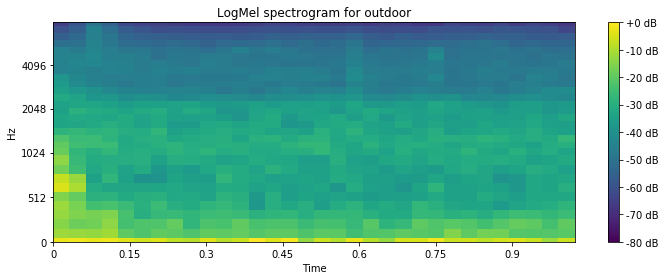

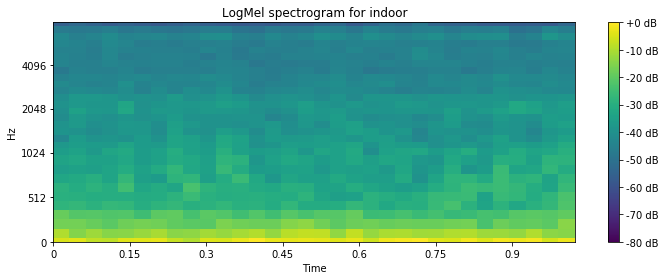

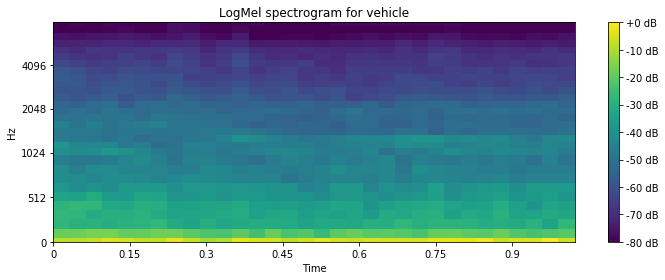

In [ ]:
plt.figure(figsize=(10, 4))
feature = x_dev_features[0]
librosa.display.specshow(feature, sr=16000, y_axis='mel', fmax=8000,
                         x_axis='time', cmap='viridis', vmin=-80.0)
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel spectrogram for ' + class_names[y_dev_features[0]])
plt.tight_layout()


plt.figure(figsize=(10, 4))
feature = x_dev_features[120 * 29]
librosa.display.specshow(feature, sr=16000, y_axis='mel', fmax=8000,
                         x_axis='time', cmap='viridis', vmin=-80.0)
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel spectrogram for ' + class_names[y_dev_features[120 * 29]])
plt.tight_layout()

plt.figure(figsize=(10, 4))
feature = x_dev_features[167 * 29]
librosa.display.specshow(feature, sr=16000, y_axis='mel', fmax=8000,
                         x_axis='time', cmap='viridis', vmin=-80.0)
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel spectrogram for ' + class_names[y_dev_features[167 * 29]])
plt.tight_layout()

## Standardize features
Standardize features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples, and s is the standard deviation of the training samples.

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split


In [ ]:
from sklearn import preprocessing

# Flatten features for scaling
x_dev_features_r = x_dev_features.reshape(len(x_dev_features), 30 * 32)
x_eval_features_r = x_eval_features.reshape(len(x_eval_features), 30 * 32)

# Create scaler using only the development dataset
scaler = preprocessing.StandardScaler().fit(x_dev_features_r)

# Apply the same scaler to the development and evaluation set 
x_dev_features_s = scaler.transform(x_dev_features_r)
x_eval_features_s = scaler.transform(x_eval_features_r)

# Save scaler
# TODO

## Split development set into *train* and *validation* set
When training, we want to check the accuracy of the model on data it hasn't seen before. So we wan to split the development dataset into a training and validation set to evaluate the loss and other model metrics at the end of each training epoch. The goal is to develop and tune the model using only the development data. The evaluation dataset will only be used for final evaluation as if it was unknown.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_dev_features_s,
                                                  y_dev_features_cat,
                                                  test_size=0.25,
                                                 random_state=1)


x_test = x_eval_features_s.reshape(len(x_eval_features), 30 * 32)
y_test = y_eval_features_cat
_, x_test_partial, _, y_test_partial = train_test_split(x_test,
                                                        y_test,
                                                        test_size=0.01)

print('Training samples:', x_train.shape)
print('Validation samples:', x_val.shape)
print('Test samples:', x_test.shape)
print('Partial Test samples:', x_test_partial.shape)

Training samples: (25447, 960)
Validation samples: (8483, 960)
Test samples: (11310, 960)
Partial Test samples: (114, 960)


## Save the features

Finally, save the features to a csv file in a format [X-CUBE-AI](https://www.st.com/en/embedded-software/x-cube-ai.html) can understand, that is, for each tensor, the values are in a flattened vector.

In [ ]:
np.savetxt('x_train.csv', x_train.reshape(len(x_train), 30 * 32), delimiter=",")
np.savetxt('y_train.csv', y_train, delimiter=",")
np.savetxt('x_val.csv', x_val.reshape(len(x_val), 30 * 32), delimiter=",")
np.savetxt('y_val.csv', y_val, delimiter=",")
np.savetxt('x_test.csv', x_test.reshape(len(x_test), 30 * 32), delimiter=",")
np.savetxt('y_test.csv', y_test, delimiter=",")
np.savetxt('x_test_partial.csv', x_test_partial.reshape(len(x_test_partial), 30 * 32), delimiter=",")
np.savetxt('y_test_partial.csv', y_test_partial, delimiter=",")

## Build the model
Now, let's build a sequential convolutional network classifier model: 

In [ ]:
from keras import layers
from keras import models
from tensorflow import set_random_seed

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(30, 32, 1), data_format='channels_last'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# print model summary
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 30, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 13, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 5193      
_________________________________________________________________
dens

## Compile the model

In [ ]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',  metrics=['acc'])

## Train the model
Now it's time to feed training data into our model. This is where a powerful CPU or even a GPU is recommended for this task.

In [ ]:
# Reshape features to include channel
x_train_r = x_train.reshape(x_train.shape[0], 30, 32, 1)
x_val_r = x_val.reshape(x_val.shape[0], 30, 32, 1)
x_test_r = x_test.reshape(x_test.shape[0], 30, 32, 1)
x_test_partial_r = x_test_partial.reshape(x_test_partial.shape[0], 30, 32, 1)

In [ ]:
# Train the model
history = model.fit(x_train_r, y_train, validation_data=(x_val_r, y_val),
                    batch_size=10, epochs=20, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 25447 samples, validate on 8483 samples
Epoch 1/20
 - 15s - loss: 0.4466 - acc: 0.8308 - val_loss: 0.2800 - val_acc: 0.8890
Epoch 2/20
 - 9s - loss: 0.2357 - acc: 0.9106 - val_loss: 0.2145 - val_acc: 0.9176
Epoch 3/20
 - 9s - loss: 0.1599 - acc: 0.9400 - val_loss: 0.1465 - val_acc: 0.9442
Epoch 4/20
 - 9s - loss: 0.1180 - acc: 0.9553 - val_loss: 0.0996 - val_acc: 0.9613
Epoch 5/20
 - 9s - loss: 0.0869 - acc: 0.9701 - val_loss: 0.0815 - val_acc: 0.9727
Epoch 6/20
 - 9s - loss: 0.0690 - acc: 0.9754 - val_loss: 0.1095 - val_acc: 0.9578
Epoch 7/20
 - 9s - loss: 0.0544 - acc: 0.9809 - val_loss: 0.0611 - val_acc: 0.9783
Epoch 8/20
 - 10s - loss: 0.0458 - acc: 0.9845 - val_loss: 0.0612 - val_acc: 0.9780
Epoch 9/20
 - 10s - loss: 0.0379 - acc: 0.9873 - val_loss: 0.1125 - val_acc: 0.9669
Epoch 10/20
 - 9s - loss: 0.0337 - acc: 0.9883 - val_loss: 0.0501 - val_acc: 0.9801
Epoch 11/20
 - 9s - loss: 0.0260 - acc: 0.9910 - val_loss: 0.0584 - v

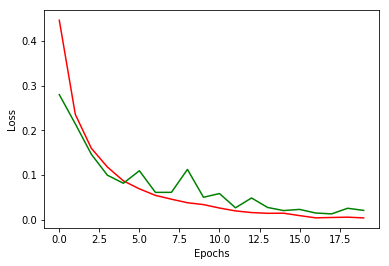

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, color='r')
plt.plot(val_loss, color='g')
plt.show()

## Evaluate accuracy
Next, compare how the model performs on the test dataset:

In [ ]:
loss_and_metrics = model.evaluate(x_test_r, y_test)

print('Test loss:', loss_and_metrics[0])
print('Test accuracy:', loss_and_metrics[1])

11310/11310 [==============================] - 1s 49us/step
Test loss: 0.7539132880330334
Test accuracy: 0.9015030946065429


Overfitting is when a machine learning model performs worse on new data than on their training data.

## Confusion Matrix

### Full validation set confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_val_r)

y_pred_class_nb = np.argmax(y_pred, axis=1)
y_true_class_nb = np.argmax(y_val, axis=1)

matrix = confusion_matrix(y_true_class_nb, y_pred_class_nb, labels=[0,1,2])
accuracy = accuracy_score(y_true_class_nb, y_pred_class_nb)

# (optional) normalize to get values in %
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

np.set_printoptions(precision=2)
print(matrix)
print("Accuracy = " + str(accuracy))

[[9.94e-01 5.29e-03 5.87e-04]
 [2.79e-03 9.97e-01 3.49e-04]
 [5.88e-03 9.04e-03 9.85e-01]]
Accuracy = 0.9926912648827065


### Partial test set confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_test_partial_r)

y_pred_class_nb = np.argmax(y_pred, axis=1)
y_true_class_nb = np.argmax(y_test_partial, axis=1)

matrix = confusion_matrix(y_true_class_nb, y_pred_class_nb, labels=[0,1,2])
accuracy = accuracy_score(y_true_class_nb, y_pred_class_nb)

# (optional) normalize to get values in %
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

np.set_printoptions(precision=2)
print(matrix)
print("Accuracy = " + str(accuracy))

[[1.   0.   0.  ]
 [0.1  0.88 0.02]
 [0.05 0.08 0.86]]
Accuracy = 0.9122807017543859


We can then use this same x_test_partial dataset to perform a *validation on target* and confirm that we are geeting similar values when running our model on STM32.

## Save the model
When saving the model in a `.h5` file format, the [X-CUBE-AI](https://www.st.com/en/embedded-software/x-cube-ai.html) tool can import the pre-training model and generate an equivalent C model optmized for STM32 devices. 

In [ ]:
# Save the model into an HDF5 file ‘model.h5’
model.save('model.h5')

## References
- https://www.tensorflow.org/tutorials/keras/basic_classification
- https://www.tensorflow.org/tutorials/keras/basic_text_classification
- https://www.tensorflow.org/tutorials/sequences/audio_recognition
